# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
## YOUR CODE HERE ##
transform = transforms.Compose([transforms.RandomVerticalFlip(0.5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Create training set and define training dataloader
## YOUR CODE HERE ##

train_data = torchvision.datasets.CIFAR10(root= './data', train = True,
                                          transform=transform, download = True)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=5,shuffle = True)


# Create test set and define test dataloader
## YOUR CODE HERE ##
test_data = torchvision.datasets.CIFAR10(root= './data', train = False,
                                        transform = transform, download = True)

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size = 5, shuffle = True)
# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show();

truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


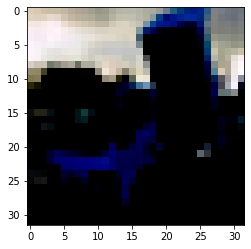

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bird


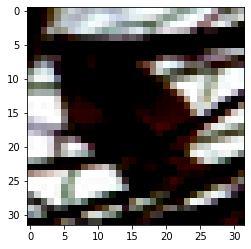

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


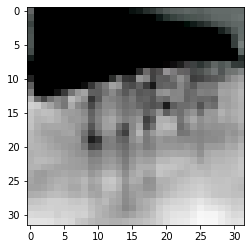

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


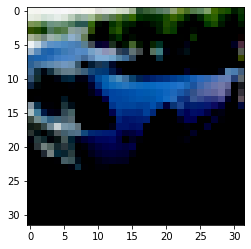

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane


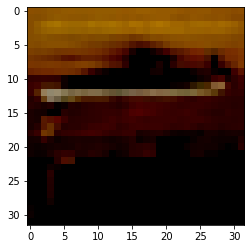

In [4]:
# Explore data
show5(train_dataloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [5]:
class Classifier(nn.Module):
    def __init__ (self):
        super().__init__ ()
        self.fc1 = nn.Linear(3072, 732)
        self.fc2 = nn.Linear(732, 500)
        self.fc3 = nn.Linear(500,64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self,x):
        
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        x = F.log_softmax(self.fc4(x), dim = 1)
        
        return x
        

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [7]:
epochs = 10
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_dataloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in test_dataloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(train_dataloader))
        test_losses.append(test_loss/len(test_dataloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_dataloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_dataloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_dataloader)))

Epoch: 1/10..  Training Loss: 1.766..  Test Loss: 1.615..  Test Accuracy: 0.430
Epoch: 2/10..  Training Loss: 1.561..  Test Loss: 1.542..  Test Accuracy: 0.459
Epoch: 3/10..  Training Loss: 1.459..  Test Loss: 1.460..  Test Accuracy: 0.483
Epoch: 4/10..  Training Loss: 1.384..  Test Loss: 1.423..  Test Accuracy: 0.497
Epoch: 5/10..  Training Loss: 1.320..  Test Loss: 1.421..  Test Accuracy: 0.496
Epoch: 6/10..  Training Loss: 1.267..  Test Loss: 1.394..  Test Accuracy: 0.506
Epoch: 7/10..  Training Loss: 1.218..  Test Loss: 1.364..  Test Accuracy: 0.522
Epoch: 8/10..  Training Loss: 1.174..  Test Loss: 1.381..  Test Accuracy: 0.525
Epoch: 9/10..  Training Loss: 1.133..  Test Loss: 1.371..  Test Accuracy: 0.526
Epoch: 10/10..  Training Loss: 1.085..  Test Loss: 1.366..  Test Accuracy: 0.531


Plot the training loss (and validation loss/accuracy, if recorded).

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

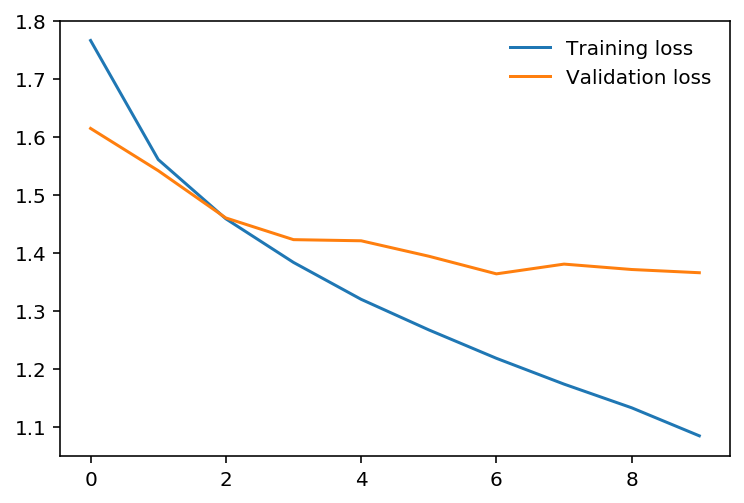

In [9]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Saving your model
Using `torch.save`, save your model for future loading.

In [11]:
torch.save(model.state_dict(), 'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

My model doesn't matcgh 70% accuracy, so it did not beat Detectocorp's algorithm.Although my model's accuracy is higher than the 45% needed for this project, it only has a 53% after training on 10 epoch. It is not as good as the models listed in the literature above, but I believe it is still doing its job.

Although my model pass the bare minimum accuracy required for this project, it can be noted that there is no problem of overfitting as the training loss and the validation losses decline over the course of the training
However, I do advise training over additional epochs to increase accuracy and applying an additional dropout layer to the model would strengthen it and make it less prone to overfitting.